In [1]:
import os
import torch
import warnings
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(4, 4))

DEVICE = torch.device('cuda:0')

from cellarium.ml.utilities.inference.cellarium_gpt_inference import \
    CellariumGPTInferenceContext

In [2]:
ROOT_PATH = "/home/mehrtash/data"
# CHECKPOINT_PATH = "/home/mehrtash/data/100M_long_run/run_001/lightning_logs/version_3/checkpoints/epoch=5-step=504000.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/10M_001_bs1536/epoch=1-step=29161__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/19M_001_bs2048/epoch=1-step=28244__updated.ckpt"
# CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/30M_001_bs2560/epoch=2-step=43129__updated.ckpt"
CHECKPOINT_PATH = "/home/mehrtash/data/mb_checkpoints/59M_001_bs3072/epoch=3-step=53770__updated.ckpt"

REF_ADATA_PATH = os.path.join(ROOT_PATH, "data", "extract_0.h5ad")
GENE_INFO_PATH = os.path.join(ROOT_PATH, "gene_info", "gene_info.tsv")

ctx = CellariumGPTInferenceContext(
    cellarium_gpt_ckpt_path=CHECKPOINT_PATH,
    ref_adata_path=REF_ADATA_PATH,
    gene_info_tsv_path=GENE_INFO_PATH,
    device=DEVICE,
    attention_backend="mem_efficient",
    verbose=False
)

In [3]:
# key_order = list(ctx.gpt_pipeline.model.metadata_vocab_sizes)

# ctx.metadata_ontology_infos = {
#     k: ctx.metadata_ontology_infos[k] for k in key_order
# }

# ctx.predict_tokenizer.metadata_vocab_sizes = {
#     k: ctx.predict_tokenizer.metadata_vocab_sizes[k] for k in key_order
# }

# ctx.predict_tokenizer.ontology_infos = {
#     k: ctx.predict_tokenizer.ontology_infos[k] for k in key_order
# }


In [7]:
adata = sc.read_h5ad(REF_ADATA_PATH)

ref_adata = adata.copy()

adata = adata[adata.obs["cell_type"] != "unknown"]
adata = adata[adata.obs["development_stage"] != "unknown"]
adata = adata[adata.obs["sex"] != "unknown"]
adata = adata[adata.obs["tissue"] != "unknown"]
adata = adata[adata.obs["disease"] != "unknown"]

adata = adata[:1000]

In [8]:
from tqdm.auto import tqdm

batch_size = 100

logits_dict_chunks = []

rng = torch.Generator().manual_seed(1)

for i in tqdm(range(0, adata.n_obs, batch_size)):
    start = i
    end = min(i + batch_size, adata.n_obs)

    # metadata_prompt_masks_dict = {
    #     "cell_type": False,
    #     "tissue": False,
    #     "development_stage": False,
    #     "disease": False,
    #     "sex": False,
    # }
    # metadata_prompt_masks_dict = {k: metadata_prompt_masks_dict[k] for k in key_order}

    tokens_dict, context_indices = ctx.generate_tokens_from_adata(
        adata=adata[start:end],
        obs_index=None,
        query_var_names=[],
        n_rand_prompt_vars=4096,
        rand_prompt_var_names_sublist=ctx.model_var_names.tolist(),
        fixed_prompt_var_names_sublist=[],
        rng=rng,
        # metadata_prompt_masks_dict=metadata_prompt_masks_dict
    )

    # convert to cuda
    tokens_dict = ctx.gpt_pipeline.transfer_batch_to_device(tokens_dict, ctx.device, 0)

    # get model predictions
    with torch.inference_mode():
        logits_dict = ctx.gpt_pipeline.model.predict(
            gene_tokens_nc=tokens_dict["gene_tokens_nc"],
            metadata_tokens_n=tokens_dict["metadata_tokens_n"],
            prompt_mask_nc=tokens_dict["prompt_mask_nc"])
        
    # transfer to numpy and cpu and keep track
    logits_dict.pop('gene_value', None)
    logits_dict_numpy = {k: v.cpu().numpy() for k, v in logits_dict.items()}
    logits_dict_chunks.append(logits_dict_numpy)

# concatenate all chunks
logits_dict = {k: np.concatenate([d[k] for d in logits_dict_chunks]) for k in logits_dict_chunks[0].keys()}

  0%|          | 0/10 [00:00<?, ?it/s]

Text(0, 0.5, 'True label')

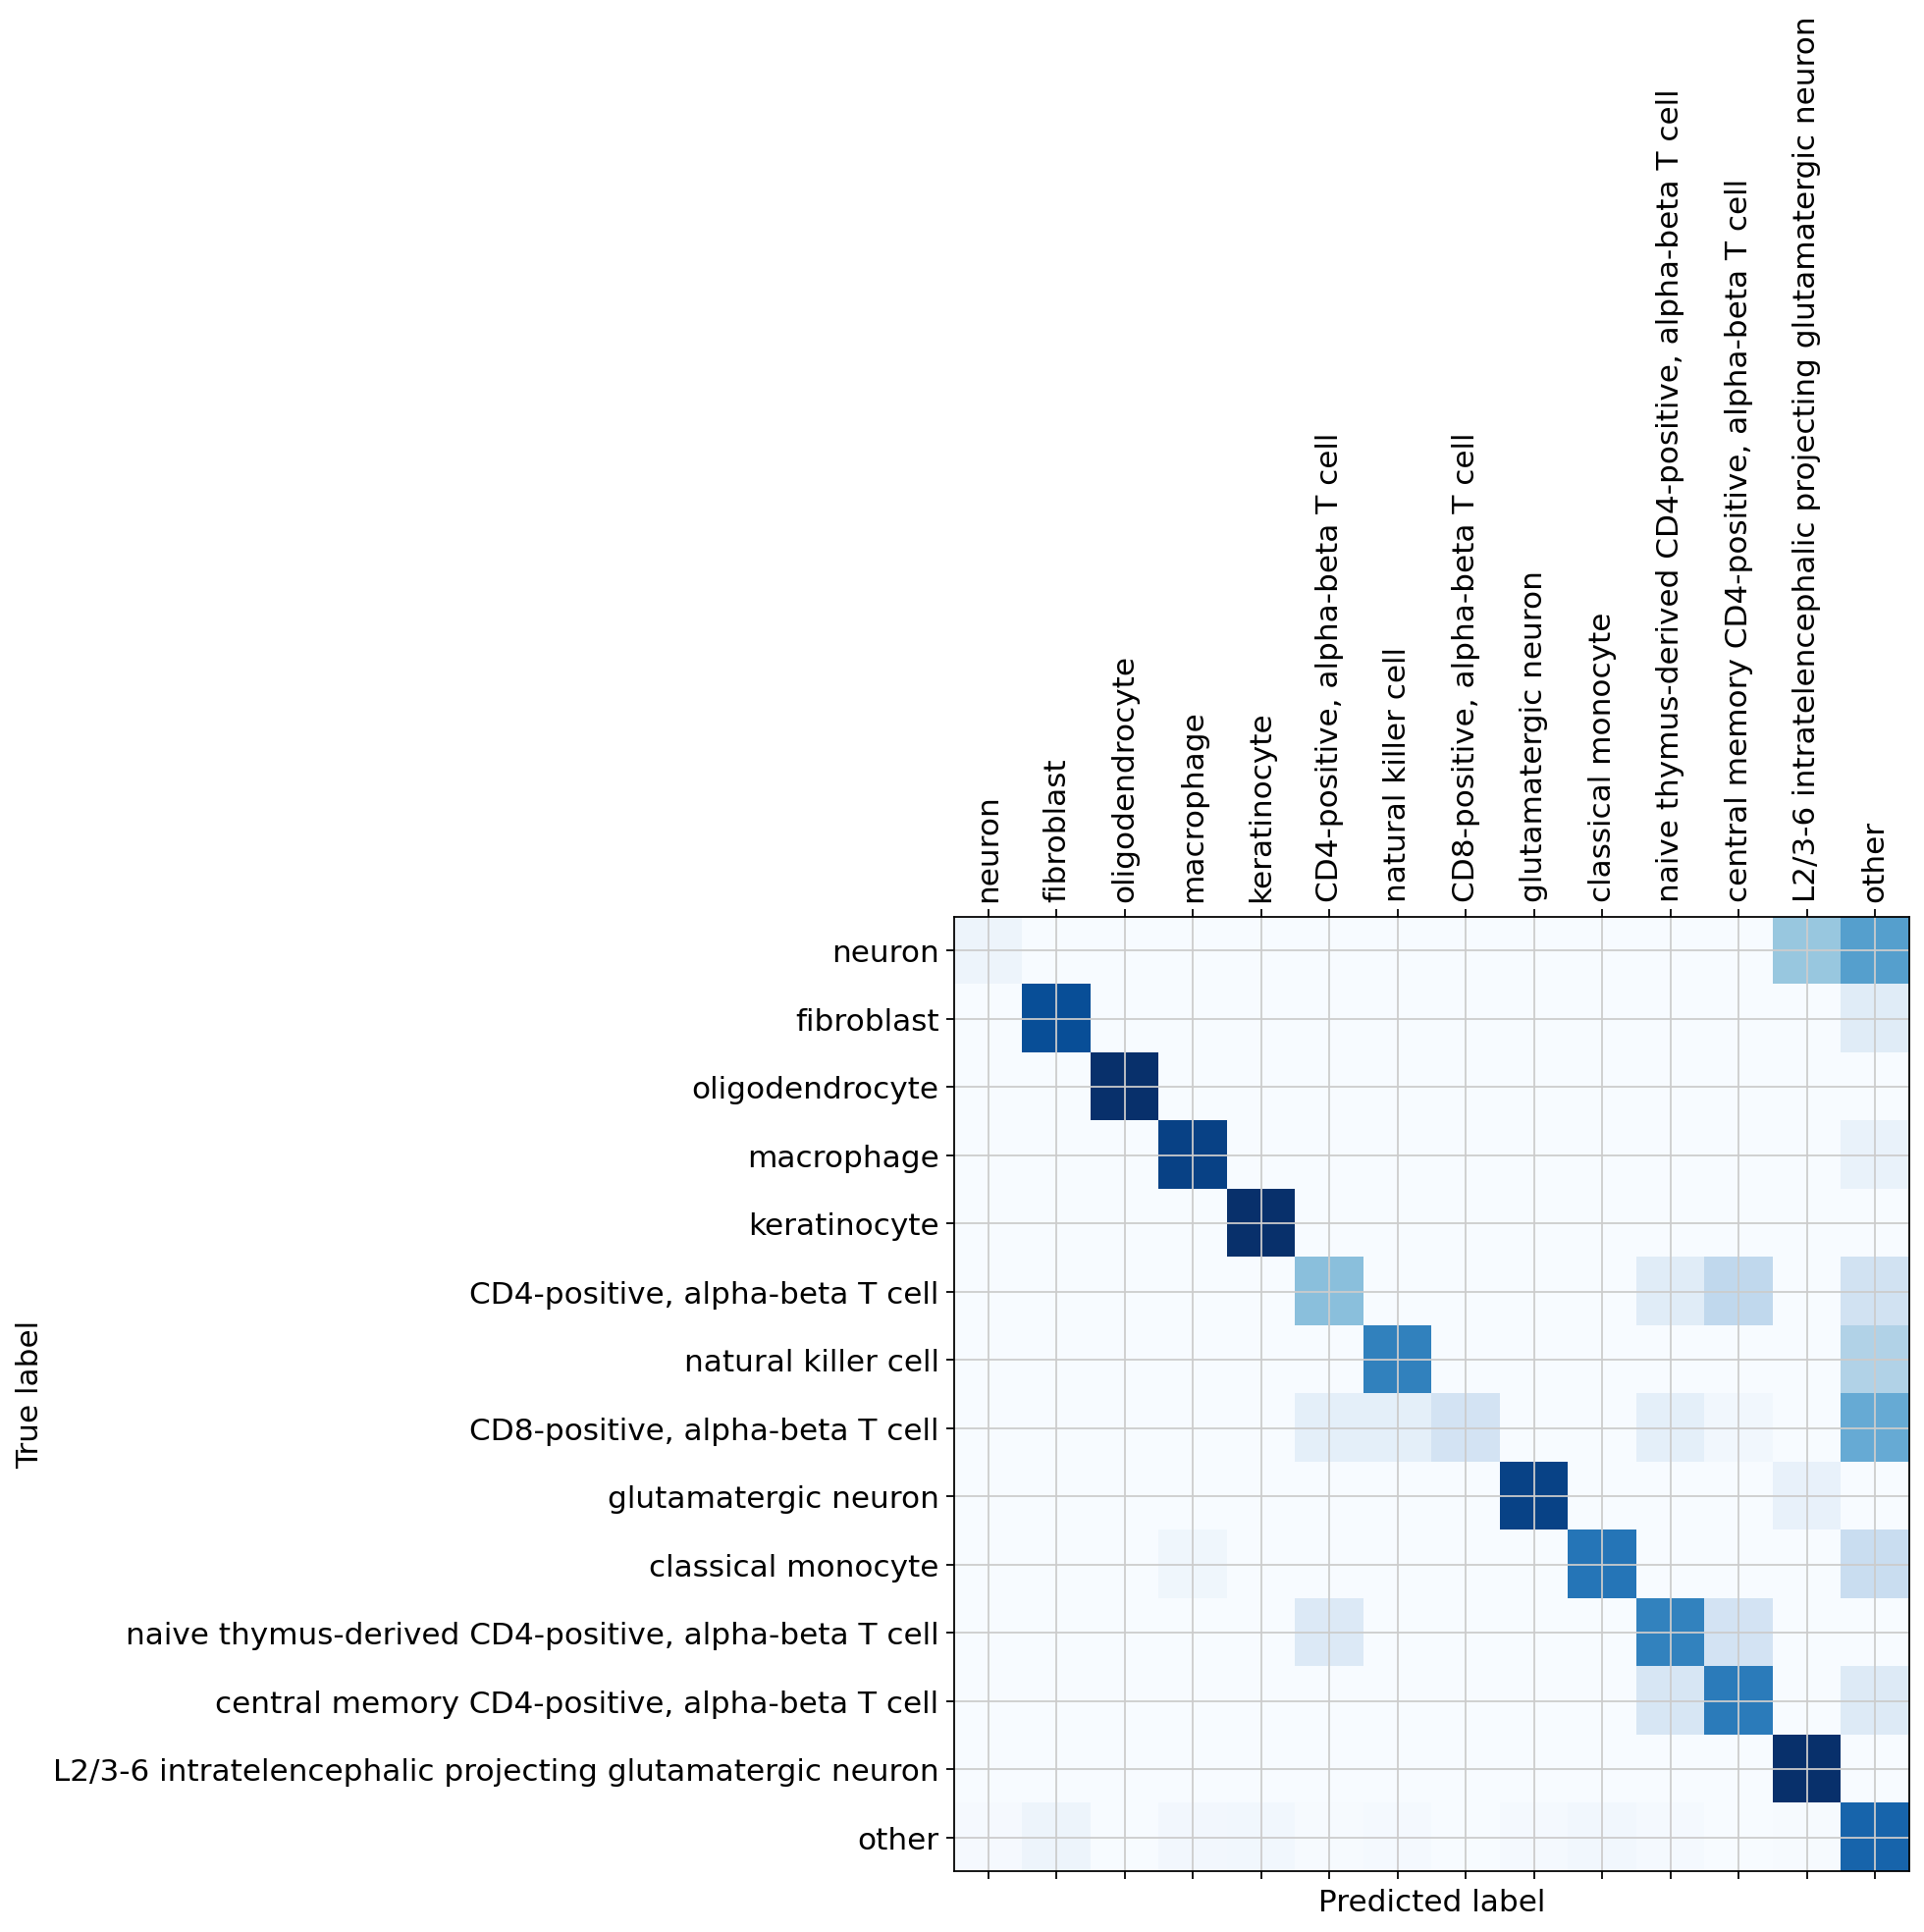

In [12]:
metadata_key = 'cell_type'
metadata_token_ctx_idx = context_indices[f'query_{metadata_key}']

# metadata_token_ctx_idx = tokens_dict['gene_tokens_nc']['gene_id'].shape[-1] + 4

logits_nk = logits_dict[metadata_key][:, metadata_token_ctx_idx, :]

assert logits_nk.shape[-1] == len(ctx.metadata_ontology_infos[metadata_key]['labels'])
                       
mapper = {label: idx for idx, label in enumerate(ctx.metadata_ontology_infos[metadata_key]['labels'])}
mapper["unknown"] = np.nan
labels_n = adata.obs[metadata_key].values
codes_n = np.asarray([mapper[label] for label in labels_n])
good_indices = np.where(~np.isnan(codes_n))[0]
codes_n = codes_n[good_indices].astype(int)
labels_n = labels_n[good_indices]
pred_codes_n = np.argmax(logits_nk, axis=-1)[good_indices]
pred_labels_n = np.asarray(ctx.metadata_ontology_infos[metadata_key]['labels'])[pred_codes_n]

import pandas as pd

df = pd.DataFrame({
    'codes': codes_n,
    'labels': labels_n,
    'pred_codes': pred_codes_n,
    'pred_labels': pred_labels_n
})



from sklearn.metrics import confusion_matrix

top_n_expected = 10
top_n_pred = 10
expected_codes_set = set(df["codes"].value_counts().head(top_n_expected).index)
predicted_codes_set = set(df["pred_codes"].value_counts().head(top_n_pred).index)
all_codes = sorted(expected_codes_set.union(predicted_codes_set))
other_code = np.max(all_codes) + 1

_df = df.copy()
_df["codes"] = _df["codes"].apply(lambda x: x if x in all_codes else other_code)
_df["pred_codes"] = _df["pred_codes"].apply(lambda x: x if x in all_codes else other_code)

y_true = _df["codes"].values
y_pred = _df["pred_codes"].values
labels = np.asarray(ctx.metadata_ontology_infos[metadata_key]["labels"])[all_codes]
labels = list(labels) + ["other"]

cm = confusion_matrix(y_true, y_pred, labels=all_codes + [other_code], normalize='true')

# plot the confision matrix using matplotlib
fig, ax = plt.subplots(figsize=(8, 8))
cax = ax.matshow(cm, cmap='Blues')
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
ax.set_xticklabels(labels, rotation=90)
ax.set_yticklabels(labels)
ax.set_xlabel('Predicted label')
ax.set_ylabel('True label')

In [23]:
ref_adata.obs['suspension_type'].cat.categories

Index(['nucleus', 'cell'], dtype='object')